# Titanic Survival Part 3: Training Classifiers for Accuracy

In Part 1 of this project I conduct Exploratory Data Analysis (EDA) of the Titanic training data using R. This exploration can be found [here.](http://rpubs.com/BigBangData/512981)

In Part 2 I continue the exploration using Python and building a couple of basic models. This is not intended as the goal of the competition, just an exploration of modeling in Python.

In Part 3 (this notebook) I create a pre-processing pipeline and train several models in Python using the scikit-learn module, and submit my predictions to the competition.


In [1]:
from datetime import datetime
import time

dt_object = datetime.fromtimestamp(time.time())
dt_object = str(dt_object).split('.')[0]

Date, Time = dt_object.split(' ')
print('Revised on: ' + Date)

Revised on: 2020-01-19


## Pre-Processing

In [2]:
# import modules
import pandas as pd
import numpy as np

# custom pre-processing module
import processing_pipeline as pp  

# load datasets
train_data = pd.read_csv("../input/train.csv")
test_data = pd.read_csv("../input/test.csv")

# separate target from predictors in training set
survived_labels = train_data['Survived'].copy()
train_data_nolabel = train_data.drop('Survived', axis=1)

# get processed training data and labels
X = pp.process_train(train_data_nolabel)
y = survived_labels.to_numpy()

## Modeling

### Random Forests

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
import pickle

A grid search shows which are the best parameters for the highest accuracy across a range of values. Here we construct a 20 x 2 x 2 = 80-parameter grid search that explores various numbers of estimators and four main categories of models (bootsrapped or not, gini or entropy as IG criterion):


In [4]:
# load pickled model so as to skip the grid search in future notebook runs
try:
    grid_search = pickle.load(open('./RandomForest_GridSearch.sav', 'rb'))
    
except FileNotFoundError as e:
    
    num_estimators = list(range(50,5000,250))
    
    grid_param = {
        'n_estimators': num_estimators,
        'criterion': ['gini', 'entropy'],
        'bootstrap': [True, False]
    }
    
    grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                               param_grid=grid_param,
                               scoring='accuracy',
                               cv=5,
                               n_jobs=-1)
    
    # running the grid search: this takes time...
    grid_search.fit(X,y)
    
    # pickle the model for future ease
    pickle.dump(grid_search, open('./RandomForest_GridSearch.sav', 'wb'))

In [5]:
# best arameters and the best accuracy
grid_search.best_params_ , round(grid_search.best_score_, 4)

({'bootstrap': True, 'criterion': 'entropy', 'n_estimators': 300}, 0.8193)

In [6]:
import modeling_functions as mf

boot_gini, boot_entr, noot_gini, noot_entr = mf.transform_gridsearch_results(grid_search)

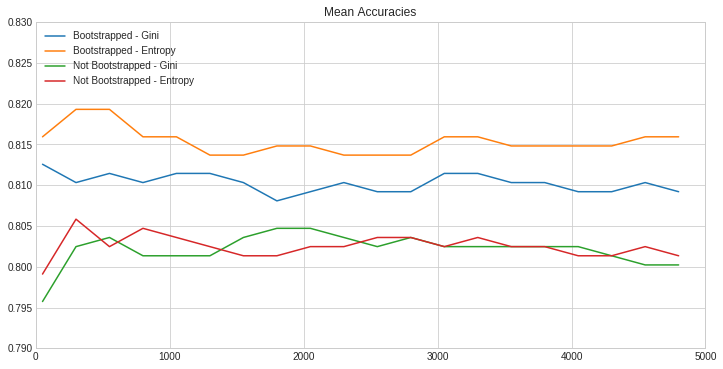

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

mf.plot_means(boot_gini, grid_search)

We can confirm that using entropy as the information gain criterion has the highest accuracies when bootstrapping - not bootstrapping is just a bad idea. 

It also looks as if we will not revisit that plateau of high accuracies around 200-500 number of estimators so we can focus our search efforts under 1000 estimators.

## Feature Selection with Random Forests

While we could stop here and train a classifier using the best parameters we found, it is often useful to verify that the full data is indeed offering the best accuracies, versus models on some optimal subset of the data.

In [8]:
from sklearn.feature_selection import SelectFromModel

# train full model on best classifier
forest_clf = RandomForestClassifier(bootstrap=True,
                                    criterion='entropy',
                                    n_estimators=300,
                                    random_state=42)
forest_clf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [9]:
# create dataframe of labels and importance scores
importance_df = pd.DataFrame(list(zip(train_data_nolabel.columns, forest_clf.feature_importances_)),
                       columns=['Labels','Importance'])

importance_df.sort_values(by=['Importance'], ascending=False, inplace=True)

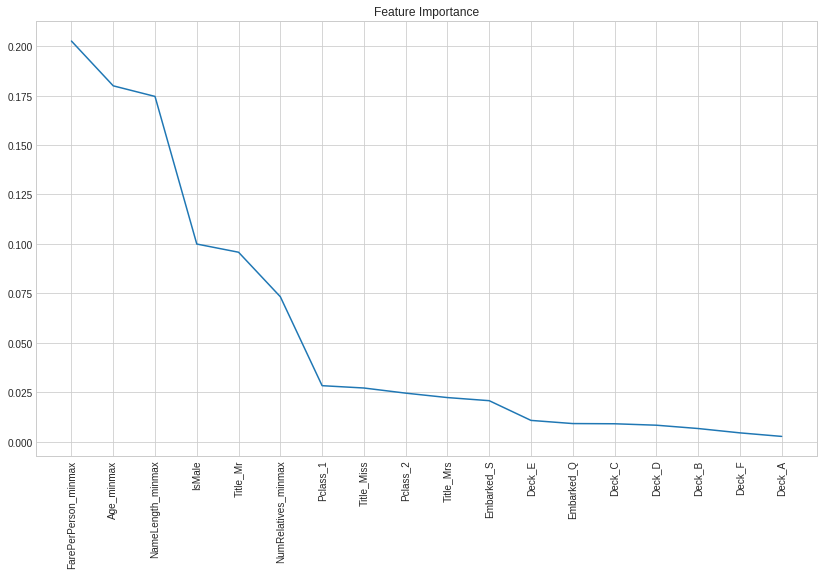

In [10]:
# plot an "elbow" plot of feature importance
plt.rcParams['figure.figsize'] = [14, 8]
mf.elbow_plot(importance_df['Labels'], importance_df['Importance'])

We could select the subset of features based on elbow method since we have such a sharp turn at the seventh feature (Pclass_1):

In [11]:
rf_sub = importance_df[importance_df['Importance'] > 0.0275]
rf_sub

,Labels,Importance
17,FarePerPerson_minmax,0.202602
14,Age_minmax,0.179958
15,NameLength_minmax,0.174600
0,IsMale,0.099940
3,Title_Mr,0.095792
16,NumRelatives_minmax,0.073285
6,Pclass_1,0.028296


Notice that this is similar to using the `feature_selection` module from scikit-learn, which require a threshold to be used just as we did above.

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# split data into 20% test and 80% training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [13]:
# train full model
forest_clf = RandomForestClassifier(bootstrap=True,
                                    criterion='entropy',
                                    n_estimators=300,
                                    random_state=42)
forest_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [14]:
# select best subset
sfm = SelectFromModel(forest_clf, threshold=0.025)

sfm.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True,
                                                 class_weight=None,
                                                 criterion='entropy',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=300, n_jobs=None,
                                                 oob_score=False,
                                                 random_state=42, verbose=0,
 

In [15]:
# create subsets with most important features
X_important_train = sfm.transform(X_train)
X_important_test = sfm.transform(X_test)

In [16]:
# train a new model on this subset
clf_important =  RandomForestClassifier(bootstrap=True,
                                        criterion='entropy',
                                        n_estimators=300,
                                        random_state=42)

clf_important.fit(X_important_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [17]:
# predict on the test set using the full dataset
y_pred = forest_clf.predict(X_test)

accuracy_score(y_test, y_pred)

0.8268156424581006

In [18]:
# predict on the test set using the important subset model
y_important_pred = clf_important.predict(X_important_test)

accuracy_score(y_test, y_important_pred)

0.8044692737430168

## Recursive Feature Elimination with Cross Validation

In [19]:
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.33, 
                                                    random_state=42)

# feature selection classifier
clf_feature_select = RandomForestClassifier(bootstrap=True,
                                            criterion='entropy',
                                            n_estimators=300,
                                            random_state=42)

# recursive feature elimination with cross validation
rfecv = RFECV(estimator=clf_feature_select, 
              step=1, 
              cv=5, 
              scoring = 'accuracy')

# grid search final classifier
final_clf = RandomForestClassifier(random_state=42)

CV_rfc = GridSearchCV(estimator=final_clf,
                      param_grid={
                           'n_estimators': list(range(200,550,15)),
                           'criterion': ['gini', 'entropy'],
                           'bootstrap': [True]
                       },                      
                      scoring='accuracy',
                      cv=5,
                      n_jobs=-1)

rf_pipeline  = Pipeline([('feature_select', rfecv),
                         ('classifier_CV', CV_rfc)])

In [20]:
try:
    rf_pipeline = pickle.load(open('./rfecv_rf_pipeline.sav', 'rb'))
except FileNotFoundError as e:
    rf_pipeline.fit(X_train, y_train)
    pickle.dump(rf_pipeline, open('./rfecv_rf_pipeline.sav', 'wb'))

In [21]:
rf_pipeline['classifier_CV'].best_params_, rf_pipeline['classifier_CV'].best_score_

({'bootstrap': True, 'criterion': 'entropy', 'n_estimators': 395},
 0.8238255033557047)

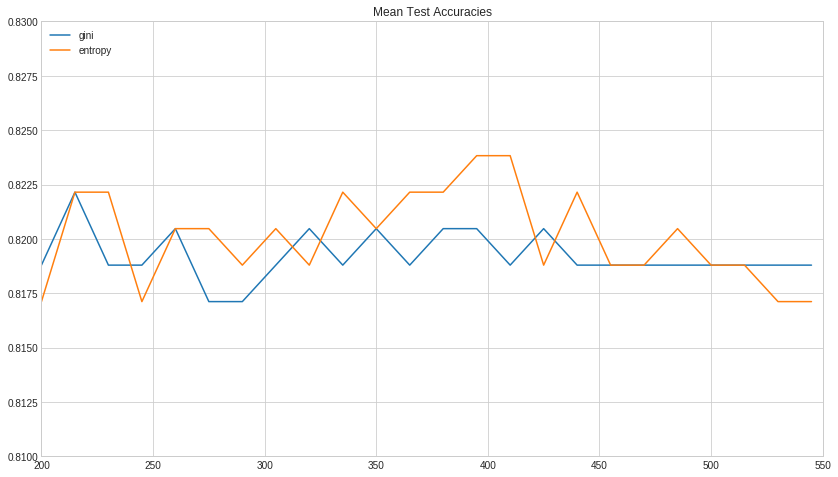

In [22]:
n_estimators = list(rf_pipeline['classifier_CV'].cv_results_['param_n_estimators'][:24])
gini_mean_test_scores = rf_pipeline['classifier_CV'].cv_results_['mean_test_score'][:24]
entr_mean_test_scores = rf_pipeline['classifier_CV'].cv_results_['mean_test_score'][24:]

plt.plot(n_estimators, gini_mean_test_scores, label='gini')
plt.plot(n_estimators, entr_mean_test_scores, label='entropy')
plt.axis([200, 550, .81, .83]) 
plt.title('Mean Test Accuracies')
plt.legend(loc='upper left')
plt.show()

In [23]:
rf_predictions = rf_pipeline.predict(X_test)

rf_acc = accuracy_score(rf_predictions, y_test)
print("Accuracy: %.2f%%" % (rf_acc * 100.0))

Accuracy: 80.68%


In [24]:
# best model
rf_clf = RandomForestClassifier(bootstrap=True,
                                criterion='entropy',
                                n_estimators=395,
                                random_state=462)

rf_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=395,
                       n_jobs=None, oob_score=False, random_state=462,
                       verbose=0, warm_start=False)

In [25]:
best_preds = rf_clf.predict(X_test)
rf_best_acc = accuracy_score(best_preds, y_test)
print("Accuracy: %.2f%%" % (rf_best_acc * 100.0))

Accuracy: 81.69%


## XGBoost 

In [26]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier()

xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [27]:
y_pred = xgb_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 84.41%


## Cross Validation, Feature Selection, Tuning with XGBoost 

In [28]:
xgb_clf = XGBClassifier(objective='binary:logistic', 
                        colsample_bytree=0.8, 
                        learning_rate=0.1,
                        max_depth=5, 
                        reg_alpha=10, 
                        n_estimators=10,
                        random_state=81)

xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=10, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=81,
              reg_alpha=10, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [29]:
y_pred = xgb_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 82.71%


### k-Fold Cross Validation using XGBoost

First we create a data matrix object for optimization.

In [30]:
from xgboost import DMatrix

data_dmatrix = DMatrix(data=X, label=y)

In [31]:
from xgboost import cv

params = {"objective":"binary:logistic",
          'colsample_bytree': 0.8,
          'learning_rate': 0.1,
          'max_depth': 5, 
          'alpha': 10}

cv_results = cv(dtrain=data_dmatrix, 
                params=params, 
                nfold=5,
                num_boost_round=10,
                early_stopping_rounds=20,
                metrics="error", 
                as_pandas=True, 
                seed=81)

In [32]:
cv_results

,train-error-mean,train-error-std,test-error-mean,test-error-std
0,0.218011,0.007635,0.236777,0.035863
1,0.193038,0.017635,0.201990,0.031755
2,0.176767,0.020511,0.187389,0.025161
3,0.173962,0.009388,0.186266,0.032156
4,0.179011,0.014303,0.186266,0.024591
5,0.177606,0.016288,0.184031,0.021412
6,0.173399,0.009785,0.182907,0.025243
7,0.173680,0.009948,0.180654,0.028852
8,0.173119,0.008609,0.181777,0.028243
9,0.171153,0.009747,0.182901,0.028915


In [33]:
params = {"objective":"binary:logistic",
          'colsample_bytree': 0.8,
          'learning_rate': 0.1,
          'max_depth': 3, 
          'reg_alpha': 1}

cv_results = cv(dtrain=data_dmatrix, 
                params=params, 
                nfold=5,
                num_boost_round=150,
                early_stopping_rounds=20,
                metrics="error", 
                as_pandas=True, 
                seed=42)

In [34]:
cv_results

,train-error-mean,train-error-std,test-error-mean,test-error-std
0,0.191920,0.010594,0.215454,0.035397
1,0.174523,0.012896,0.194168,0.021825
2,0.168912,0.010070,0.188550,0.020268
3,0.164145,0.010777,0.182932,0.025952
4,0.164143,0.006510,0.182932,0.025952
5,0.165826,0.008686,0.169462,0.022215
6,0.165546,0.006620,0.170579,0.019826
7,0.165264,0.004504,0.170579,0.022228
8,0.163862,0.006565,0.167215,0.021027
9,0.161898,0.005964,0.166091,0.022524


In [35]:
try:
    grid_search = pickle.load(open('./XGBoost_GridSearch.sav', 'rb'))
        
except FileNotFoundError as e:
    
    grid_param = {
        'colsample_bytree': [0.5, 0.6, 0.7, 0.8],
        'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1],
        'max_depth': [1, 3, 5, 7, 9],
        'reg_alpha': [1, 3, 5, 7, 9],
        'n_estimators': [10, 50, 100, 250]
    }
    
    grid_search = GridSearchCV(estimator=XGBClassifier(objective='binary:logistic', 
                                                       random_state=42),
                               param_grid=grid_param,
                               scoring='accuracy',
                               cv=5,
                               n_jobs=-1)
    grid_search.fit(X, y)
    
    pickle.dump(grid_search, open('./XGBoost_GridSearch.sav', 'wb'))

In [36]:
print("Accuracy: %.2f%%" % (grid_search.best_score_ * 100.0))

Accuracy: 83.84%


In [37]:
grid_search.best_params_

{'colsample_bytree': 0.8,
 'learning_rate': 0.1,
 'max_depth': 3,
 'n_estimators': 250,
 'reg_alpha': 1}

Defaults are:

     XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [38]:
try:
    grid_search = pickle.load(open('./XGBoost_GridSearch2.sav', 'rb'))
        
except FileNotFoundError as e:
    
    grid_param = {
        'colsample_bytree': [0.8, 0.9, 1.0],
        'learning_rate': [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5],
        'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
    }
    
    grid_search = GridSearchCV(estimator=XGBClassifier(objective='binary:logistic', 
                                                       random_state=42),
                               param_grid=grid_param,
                               scoring='accuracy',
                               cv=5,
                               n_jobs=-1)
    grid_search.fit(X, y)
    
    pickle.dump(grid_search, open('./XGBoost_GridSearch2.sav', 'wb'))

In [39]:
print("Accuracy: %.2f%%" % (grid_search.best_score_ * 100.0))

Accuracy: 83.95%


In [40]:
grid_search.best_params_

{'colsample_bytree': 0.8, 'learning_rate': 0.15, 'n_estimators': 150}

Testing the accuracy of this latest model with the same train/test samples of the original XGBoost classifier (with defaults).

In [41]:
xgb_clf = XGBClassifier(objective='binary:logistic', 
                        colsample_bytree=0.8, 
                        learning_rate=0.15,
                        n_estimators=150,
                        random_state=42)

xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.15, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=150, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [42]:
y_pred = xgb_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 84.41%


In [43]:
try:
    grid_search = pickle.load(open('./XGBoost_GridSearch3.sav', 'rb'))
        
except FileNotFoundError as e:
    
    grid_param = {
        'learning_rate': [x/100 for x in range(10, 22)],
        'n_estimators': [x for x in range(100, 205, 5)]
    }
    
    grid_search = GridSearchCV(estimator=XGBClassifier(objective='binary:logistic',
                                                       colsample_bytree=0.8,
                                                       random_state=42),
                               param_grid=grid_param,
                               scoring='accuracy',
                               cv=5,
                               n_jobs=-1)
    grid_search.fit(X, y)
    
    pickle.dump(grid_search, open('./XGBoost_GridSearch3.sav', 'wb'))

In [44]:
print("Accuracy: %.2f%%" % (grid_search.best_score_ * 100.0))

Accuracy: 83.95%


In [45]:
grid_search.best_params_

{'learning_rate': 0.15, 'n_estimators': 150}

In [46]:
l_0, l_1, l_2, l_3, l_4, l_5, l_6, l_7, l_8, l_9, l_10, l_11 = mf.transform_gridsearch_results2(grid_search)

In [47]:
l_0.head()

,learning_rate,n_estimators,cv0,cv1,cv2,cv3,cv4
0,0.1,100,0.810056,0.843575,0.803371,0.808989,0.841808
1,0.1,105,0.810056,0.837989,0.803371,0.808989,0.841808
2,0.1,110,0.810056,0.843575,0.803371,0.808989,0.841808
3,0.1,115,0.810056,0.837989,0.814607,0.808989,0.841808
4,0.1,120,0.804469,0.832402,0.820225,0.808989,0.841808


### We can observe accuracies in detail for each CV fold and various learning rates.

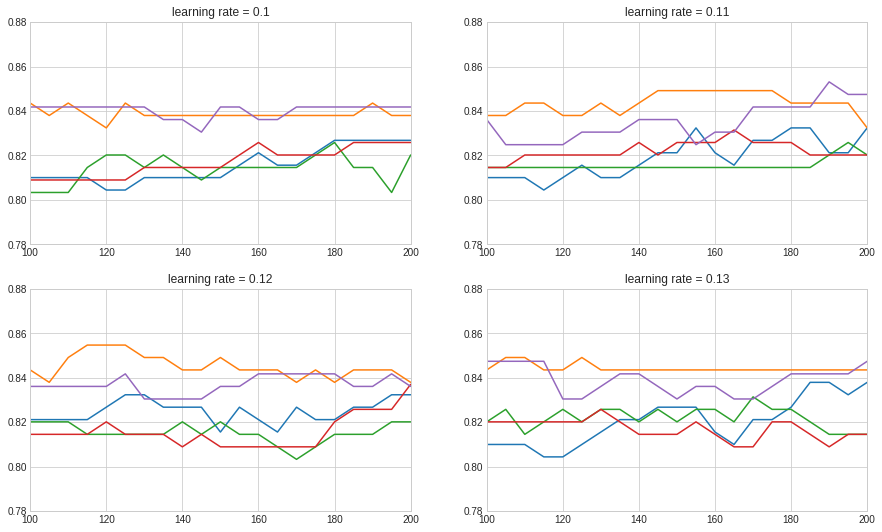

In [48]:
mf.plot_single2(l_0, 1, 'learning rate = 0.1')
mf.plot_single2(l_1, 2, 'learning rate = 0.11')
mf.plot_single2(l_2, 3, 'learning rate = 0.12')
mf.plot_single2(l_3, 4, 'learning rate = 0.13')

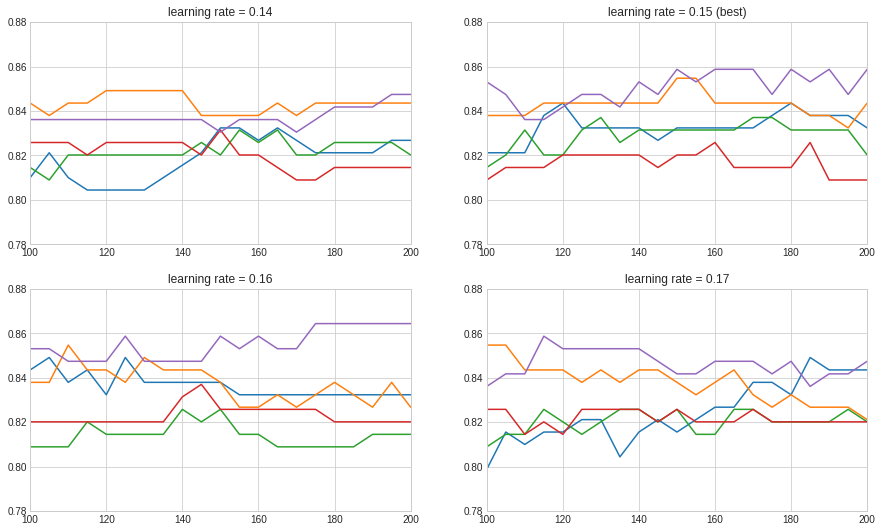

In [49]:
mf.plot_single2(l_4, 1, 'learning rate = 0.14')
mf.plot_single2(l_5, 2, 'learning rate = 0.15 (best)')
mf.plot_single2(l_6, 3, 'learning rate = 0.16')
mf.plot_single2(l_7, 4, 'learning rate = 0.17')

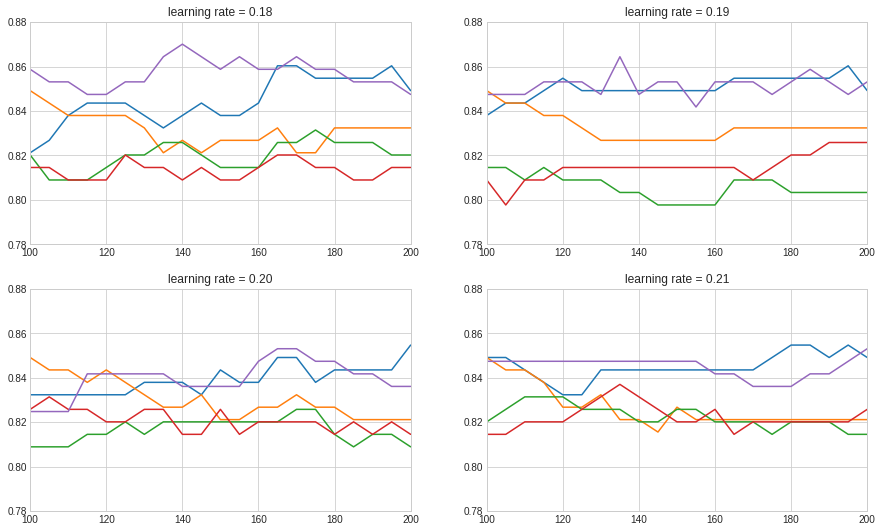

In [50]:
mf.plot_single2(l_8, 1, 'learning rate = 0.18')
mf.plot_single2(l_9, 2, 'learning rate = 0.19')
mf.plot_single2(l_10, 3, 'learning rate = 0.20')
mf.plot_single2(l_11, 4, 'learning rate = 0.21')

### We can observe the mean accuracy for all learning rates.

In [51]:
def plot_means2(df, grid_search):
    """Given four dataframes (subsets) and original grid search object, 
    construct a line plot for the mean accuracy per number of estimators 
    for each dataframe.
    """

    x = list(df['n_estimators'])
    plt.rcParams['figure.figsize'] = [14, 12]
    plt.axis([100, 200, .82, .84]) 
    
    Y0 = grid_search.cv_results_['mean_test_score'][:21]
    Y1 = grid_search.cv_results_['mean_test_score'][21:42]
    Y2 = grid_search.cv_results_['mean_test_score'][42:63]
    Y3 = grid_search.cv_results_['mean_test_score'][63:84]
    Y4 = grid_search.cv_results_['mean_test_score'][84:105]
    Y5 = grid_search.cv_results_['mean_test_score'][105:126]
    
    plt.plot(x, Y0, label='learning rate = 0.1')
    plt.plot(x, Y1, label='learning rate = 0.11')
    plt.plot(x, Y2, label='learning rate = 0.12')
    plt.plot(x, Y3, label='learning rate = 0.13')
    plt.plot(x, Y4, label='learning rate = 0.14')
    plt.plot(x, Y5, label='learning rate = 0.15')

    plt.title('Mean Accuracies')
    plt.legend(loc='upper left')

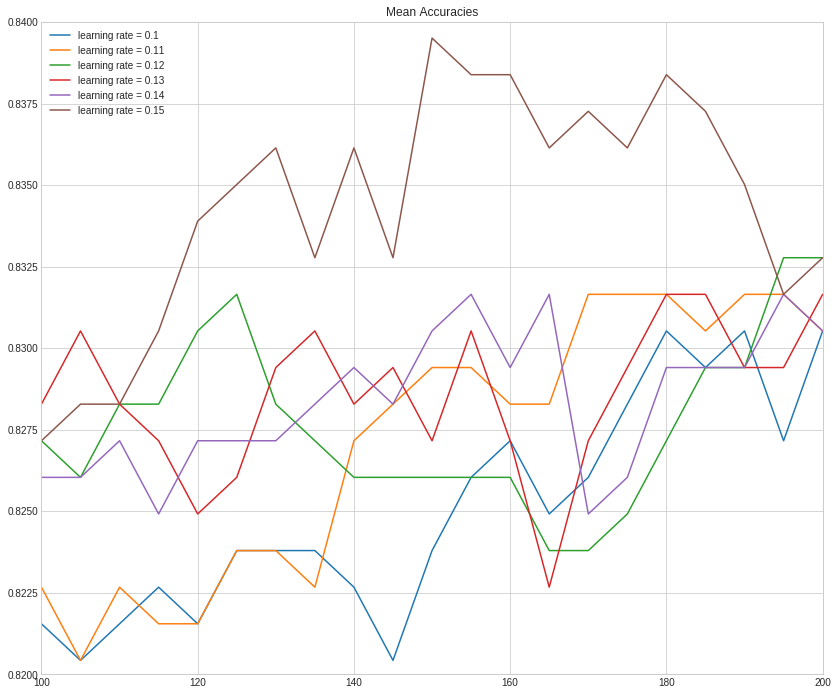

In [52]:
plot_means2(l_0, grid_search)

In [53]:
def plot_means3(df, grid_search):
    """Given four dataframes (subsets) and original grid search object, 
    construct a line plot for the mean accuracy per number of estimators 
    for each dataframe.
    """

    x = list(df['n_estimators'])
    plt.rcParams['figure.figsize'] = [14, 12]
    plt.axis([100, 200, .82, .84]) 
     
    Y5 = grid_search.cv_results_['mean_test_score'][105:126]
    Y6 = grid_search.cv_results_['mean_test_score'][126:147]
    Y7 = grid_search.cv_results_['mean_test_score'][147:168]
    Y8 = grid_search.cv_results_['mean_test_score'][168:189]
    Y9 = grid_search.cv_results_['mean_test_score'][189:210]
    Y10 = grid_search.cv_results_['mean_test_score'][210:231]        
    
    plt.plot(x, Y5, label='learning rate = 0.15')
    plt.plot(x, Y6, label='learning rate = 0.16')
    plt.plot(x, Y7, label='learning rate = 0.17')
    plt.plot(x, Y8, label='learning rate = 0.18')
    plt.plot(x, Y9, label='learning rate = 0.19')
    plt.plot(x, Y10, label='learning rate = 0.2')
    
    plt.title('Mean Accuracies')
    plt.legend(loc='upper left')

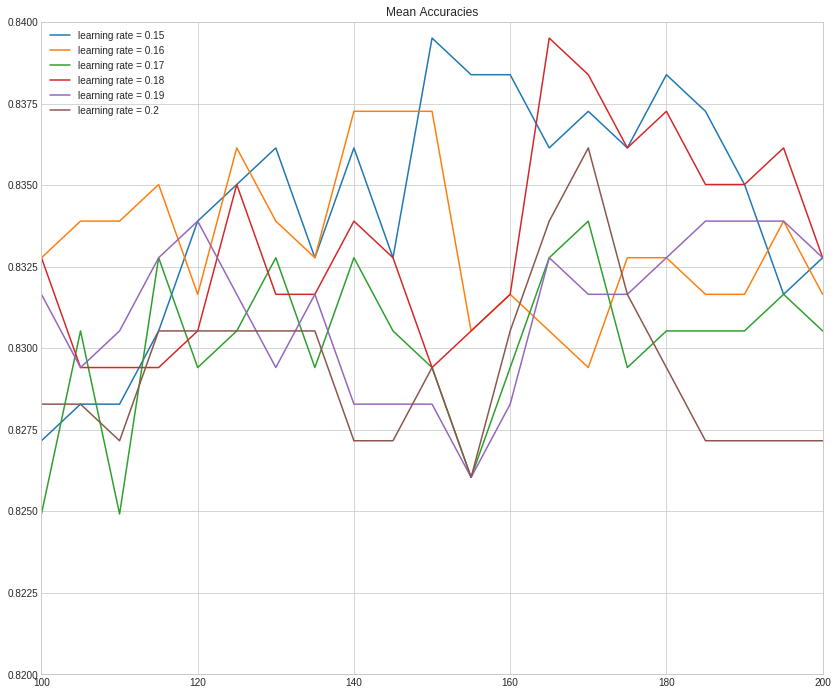

In [54]:
plot_means3(l_0, grid_search)

The best learning rate, 0.15, which peaks around 150 number of estimators, stands out from learning rates below 0.15, but is less prominent among learning rates up to 0.2, in fact learning rate 0.18 peaks similarly around 165 estimators to about 84% accuracy.

In [55]:
# testing 0.18 and 165 estimators
xgb_clf = XGBClassifier(objective='binary:logistic', 
                        colsample_bytree=0.8, 
                        learning_rate=0.18,
                        n_estimators=165,
                        random_state=42)

xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.18, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=165, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [56]:
y_pred = xgb_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 83.73%


In [57]:
# best found by grid search
xgb_clf = XGBClassifier(objective='binary:logistic', 
                        colsample_bytree=0.8, 
                        learning_rate=0.15,
                        n_estimators=150,
                        random_state=42)

xgb_clf.fit(X_train, y_train)

y_pred = xgb_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 84.41%


In [58]:
# defaults
xgb_clf = XGBClassifier(objective='binary:logistic',
                        random_state=42)

xgb_clf.fit(X_train, y_train)

y_pred = xgb_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 84.41%


Morale of the story: the grid search did not improve the sensible defaults. I could perform a randomized search or bin ages as proposed in some Titanic competition blogs and Kaggle kernel comments but I believe `XGBoost` is squeezing every ounce of information in the data and 84% is likely the best one can do, in fact it might even be overfitting a bit and we'll figure that out by simply submitting the predictions.

## Fitting Entire Train Set

In [59]:
# fitting entire train dataset 
xgb_clf.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

## Reading Test Set

In [60]:
test_data = pd.read_csv("../input/test.csv")
test_data

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


To double check that the test dataset has the same features as the unprocessed train data, I read it in again. I have to load from scratch because I overwrote the `train_data_nolabel` dataframe.

In [61]:
train_data = pd.read_csv("../input/train.csv")
train_data_nolabel = train_data.drop('Survived', axis=1)
train_data_nolabel

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
886,887,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


Now I can pre-process the test data in the same way.

## Pre-Process Test Data

In [62]:
# get processed training data and labels
# the runtime warning is triggered because in the test set we take the mean of an empty slice
test_PassengerId = test_data['PassengerId'].copy()
X_test = pp.process_train(test_data)

/home/vagrant/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1019: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [63]:
test_PassengerId

0       892
1       893
2       894
3       895
4       896
       ... 
413    1305
414    1306
415    1307
416    1308
417    1309
Name: PassengerId, Length: 418, dtype: int64

In [64]:
X_test

array([[1.        , 0.        , 1.        , ..., 0.06      , 0.        ,
        0.01528158],
       [0.        , 1.        , 0.        , ..., 0.38      , 0.1       ,
        0.01366309],
       [1.        , 0.        , 1.        , ..., 0.24      , 0.        ,
        0.01890874],
       ...,
       [1.        , 1.        , 0.        , ..., 0.3       , 0.        ,
        0.01415106],
       [1.        , 1.        , 0.        , ..., 0.12      , 0.        ,
        0.01571255],
       [1.        , 0.        , 0.        , ..., 0.22      , 0.2       ,
        0.0436405 ]])

In [65]:
X_test.shape

(418, 18)

In [66]:
y_pred = xgb_clf.predict(X_test)

In [67]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [68]:
y_pred.shape

(418,)

In [69]:
frame = { 'PassengerId': test_PassengerId, 'Survived': pd.Series(y_pred) } 
  
final_submission = pd.DataFrame(frame) 

In [70]:
final_submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [71]:
# saving as CSV
final_submission.to_csv('./final_submission.csv', index=False)

## Submission

I just submitted my first prediction in Kaggle and achieved the stunning result of being the **14,155th** entry in the leaderboard. (The leaderboard is quite heavily overfitted for this baby competition.) The XGBoost classifier which got 84.41% accuracy during validation got 73.68% accuracy on the real test set, so it lost 10% accuracy when generalizing - it was probably overfitting.

In real life, I would have to stop now, you only get one chance, but since this is Kaggle, I will submit the SGD classifier and RF classifier as well to see whether simpler models generalized better.